# Zustandsreglerentwurf

In [1]:
# 3rd party imports
import control
from IPython.display import display, Image, Latex, Markdown
import numpy as np
import sympy as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Theoretische Betrachtung

### Theorie dahinter

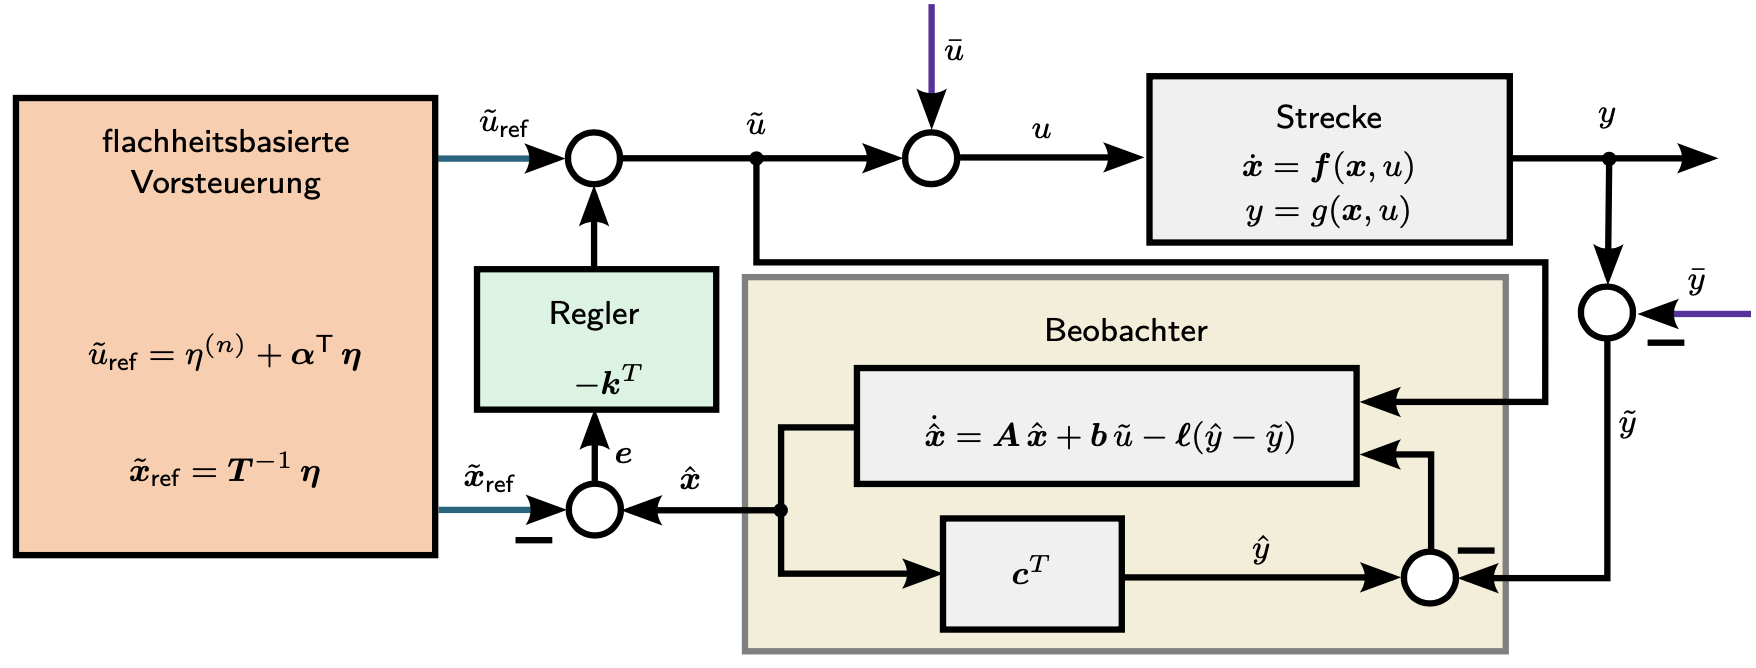

In [2]:
imag = Image("../images/zustandsregler_beobachter_vorsteuerung.png", width=600)
display(imag)

Ziel ist der Entwurf eines Zustandsreglers auf Basis des linearisierten Modells des Zweitanksystems. Das linearisierte Modell ist dabei wie folgt gegeben:

\begin{align*}

\Delta \dot{z}(t) = 
\begin{bmatrix} 
-\alpha_1 & 0 \\
\frac{A_{T,1}}{A_{T,2}} \cdot \alpha_1 & -\alpha_2
\end{bmatrix}
\cdot \Delta z(t) + 
\begin{bmatrix} 
\frac{K_u}{A_{T,1}} \\
0
\end{bmatrix}
\cdot \Delta u(t)

\end{align*}

\begin{align*}
\Delta y(t) =
\begin{bmatrix}
0 & 1
\end{bmatrix}
\cdot \Delta z(t)
\end{align*}

mit 

\begin{align*}
\alpha_1 = A_{ab,1} \cdot \sqrt{\frac{g}{2\left(\overline{z}_1+\overline{h}_{V,1}\right)\left(A^2_{T,1}-A^2_{ab,1}\right)}}
\end{align*}

\begin{align*}
\alpha_2 = A_{ab,2} \cdot \sqrt{\frac{g}{2\left(\overline{z}_2+\overline{h}_{V,2}\right)\left(A^2_{T,2}-A^2_{ab,2}\right)}}
\end{align*}

Dabei wird eine Zustandsrückführung durchgeführt. Diese kann wie folgt entworfen werden:

1. Berechnung der Zustandstransformation:
    
    a) Berechnung der Kalmanschen Steuerbarkeitsmatrix

    \begin{align*}
        S = \left(\mathbf{b}, A\mathbf{b}, \dots, A^{n-1}\mathbf{b} \right)
    \end{align*}

    b) $\mathbf{q}_1^T$ ist die letzte Zeile der inversen von $S$

    c) Berechnung der Transformationsmatrix $Q$

\begin{align*}
\begin{pmatrix} 
q^T\\
q^T A \\
\vdots \\
q^T A^{n-1}
\end{pmatrix}
\end{align*}

In [3]:
# symbole definieren
alpha1, alpha2, x1, x2, Ku, AT1, AT2, AS1, AS2, uA, hV1, hV2, g = sp.symbols('alpha_1, alpha_2, x_1, x_2, K_u, A_{T1}, A_{T2}, A_{S1}, A_{S2}, u_A, h_{V1}, h_{V2}, g')

### nichtlineares System:

In [4]:
a1 = AS1 * sp.sqrt(2 * g / (AT1**2 - AS1**2))
a2 = AS2 * sp.sqrt(2 * g / (AT2**2 - AS2**2))

dx1 = - a1 * sp.sqrt(x1 + hV1) + Ku / AT1 * uA
dx2 = - a2 * sp.sqrt(x2 + hV2) + a1 * sp.sqrt(x1 + hV1) * AT1 / AT2

dx = sp.Matrix([[dx1], [dx2]]);

# Berechnung der Ruhelagen:
u_quer = sp.symbols('u_{quer}')
x1_quer = ((AT1**2 - AS1**2) * Ku**2) / (2 * (AT1 * AS1)**2 * g) * u_quer**2 - hV1
x2_quer = ((AT1 * AS1) / (AT2 * AS2))**2 * (AT2**2 - AS2**2) / (AT1**2 - AS1**2) * (x1_quer + hV1) - hV2

### linearisiertes System

In [5]:
# Linearisierung um die Ruhelage
alpha1 = AS1 * sp.sqrt(g / (2 * (x1_quer + hV1) * (AT1**2 - AS1**2)))
alpha2 = AS2 * sp.sqrt(g / (2 * (x2_quer + hV2) * (AT2**2 - AS2**2)))


x = sp.Matrix([[x1], [x2]]);
A = sp.Matrix([[-alpha1, 0], [AT1/AT2 * alpha1, -alpha2]])
b = sp.Matrix([[Ku/AT1], [0]])
cT = sp.Matrix([[0, 1]])

### Transformation des Systems in RNF

In [6]:
# Berechnung der Steuerbarkeitsmatrix
S = sp.Matrix(sp.BlockMatrix([b, A*b]));

# Berechnung des Vektors
qT = S.inv()[-1, :];

# Berechnung der Transformationsmatrix Q (in die RNF)
Q = sp.Matrix(sp.BlockMatrix([[qT], [qT * A]]))

# Transformation des Systems in RNF
A_rnf = Q * A * Q.inv()
b_rnf = Q * b
cT_rnf = cT * Q.inv()

### Übergang zu numerischen Werten

In [7]:
rT1 = 0.060195545420039     # m - effektiver Radius des Tank 1
rT2 = 0.060195545420039     # m - effektiver Radius des Tank 2

settings = {AS1: 4.639266e-05, 
            AS2: 3.302590e-05, 
            AT1:np.pi * rT1 ** 2, 
            AT2:np.pi * rT2 ** 2, 
            g:9.81, Ku:2.46597e-05, 
            hV1: 0.055, 
            hV2: 0.055, 
            uA:6.4, 
            u_quer:2.6        # entspricht also 6.4 + 2.6 = 9V
            }

In [8]:
# Hier jetzt einen konkreten Linearisierungspunkt angegeben (siehe settings wert oben für u_quer)
A_num = A.subs(settings)
b_num = b.subs(settings)
cT_num = cT.subs(settings)

A_rnf_num = A_rnf.subs(settings)
b_rnf_num = b_rnf.subs(settings)
Q_num = Q.subs(settings)

# dementsprechend auch die Ruhelagen für x1 und x2 quer berechnen
x1_quer_num = x1_quer.subs(settings)
x2_quer_num = x2_quer.subs(settings)

In [9]:
poles = [-1, -1]
kT = control.acker(A_rnf_num, b_rnf_num, poles)

## Simulation

Definition nichtlineares Modell

In [10]:
def nonLinSys(t, z, uA):
    z1 = z[0]
    z2 = z[1]
        
    hV1 = 0.055
    hV2 = 0.055
    
    dz = np.zeros(2)
    dz[0] = 0.00216625315586689 * (uA - 6.4) - 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1)
    dz[1] = 0.0127646468529449 * np.sqrt(2) * np.sqrt(hV1 + z1) - 0.00908683019582126 * np.sqrt(2) * np.sqrt(hV2 + z2)

    return dz

Definition linearisiertes Modell

In [11]:
def linSys(t, x, uA, T1Sys, T2Sys, KSys, buA):
    A = np.array([[0, 1],
                  [-1 / (T1Sys * T2Sys), -(T1Sys + T2Sys) / (T1Sys * T2Sys)]])
    B = np.array([[0],
                  [KSys / (T1Sys * T2Sys)]])
    return A.dot(x) + B.dot(np.array([uA - buA]))

Definition Steuerung

In [12]:
class Steuerung:
    def __init__(self, z20, z21, t0, t1, T1, T2, K):
        self.z20 = z20
        self.z21 = z21
        self.t0 = t0
        self.t1 = t1
        self.dt = t1 - t0
        self.a0 = 1 / (T1 * T2)
        self.a1 = (T1 + T2) / (T1 * T2)
        self.b = K / (T1 * T2)

        tau = sp.symbols('\\tau')
        self.phi = 6 * tau ** 5 - 15 * tau ** 4 + 10 * tau ** 3
        self.dphi = self.phi.diff(tau)
        self.ddphi = self.phi.diff(tau, 2)
        
        self.z2r = lambda t: self.z20 + (self.z21 - self.z20) * self.phi.subs({tau: t / self.dt}) if 0 <= t <= self.dt else z20 if t < 0 else self.z21 
        self.dz2r = lambda t: (self.z21 - self.z20) * self.dphi.subs({tau: t / self.dt}) / self.dt if 0 < t < self.dt else 0
        self.ddz2r = lambda t: (self.z21 - self.z20) * self.ddphi.subs({tau: t / self.dt}) / self.dt ** 2 if 0 < t < self.dt else 0
        self.uAr = lambda t: 1/ self.b * (self.ddz2r(t) + self.a1 * self.dz2r(t) + self.a0 * self.z2r(t))

    def run(self, t):
        return self.z2r(t), self.uAr(t)    

Definition Regler

ÜBERLEGUNG: Der Zustandsregler kriegt den linearisierten Systemzustand. Dieser wird durch die Matrix Q transformiert. Wenn ich auch den Zustand, den ich von der Vorsteuerung bekomme mit der Matrix Q transformiere bin ich den gleichen Koordinaten und kann einen Fehler e berechnen.

Dieser Fehler ist im Falle eines Zustandsreglers zweidimensional. Er wird anschließend mit dem kT multipliziert, was den Reglerausgang ergibt. Die Zustände, welche verwendet werden um den Fehler zu berechnen müssen deshalb transformiert werden, da auch die Matrizen, welche zur Berechnung der Reglerverstärkung kT herangezogen wurden in der RNF waren.

Auf den Reglerausgang muss dann noch der Anteil der Steuerung und jender der Linearisierung dazuaddiert werden.

In [30]:
class ReglerZustand:
    def __init__(self, Q, kT, outMin, outMax, buA):
        self.Q = np.matrix(Q)
        self.kT = kT[0]
        self.outMin = outMin - buA
        self.outMax = outMax - buA
        self.buA = buA

    def run(self, x):
        # der Zustand muss in linearen Koordinaten sein (??)
        # x[0] -= x1_quer_num
        # x[1] -= x2_quer_num

        # diese dann in die RNF Transformieren (später beim Einbau der Steuerung, auch die etas in die RNF transformieren)
        x = x.reshape(2,1)
        x_RNF = self.Q * x

        out = -self.kT * x_RNF

        if out < self.outMin:
            out = self.outMin
        elif out > self.outMax:
            out = self.outMax

        return out + self.buA

In [31]:
# Physikalisch
KPhy = 0.147763421835044
T1Phy = 34.567259359529
T2Phy = 68.2115206317666
bz2Phy = 0.137092448385557
# Messung
KMessung = 0.05335540886113588
T1Messung = 11.796537856412515
T2Messung = 80.74097989401139
bz2Messung = 0.13238994944989588

In [32]:
timeDom = np.linspace(0, 500, 10001)
z0 = [0, 0]
# z2Soll = 0.12
dt = 150

regler = ReglerZustand(Q_num, kT, 0, 12, 9)
# steuerung = Steuerung(0 - bz2Messung, z2Soll - bz2Messung, 0, dt, T1Messung, T2Messung, KMessung)

In [33]:
zPhyNichtLin = np.zeros((2, len(timeDom)))
uPhyNichtLin = np.zeros((len(timeDom),))
                   
for idx, _t in enumerate(timeDom[1:]):
    z0PhyNichtLin = zPhyNichtLin[:, idx]
    uPhyNichtLin[idx] = regler.run(z0PhyNichtLin)

    resPhyNichtLin = solve_ivp(nonLinSys,
                               [timeDom[idx], timeDom[idx + 1]],
                               z0PhyNichtLin,
                               args=(uPhyNichtLin[idx], ))
    zPhyNichtLin[:, idx + 1] = resPhyNichtLin.y.T[-1, :]

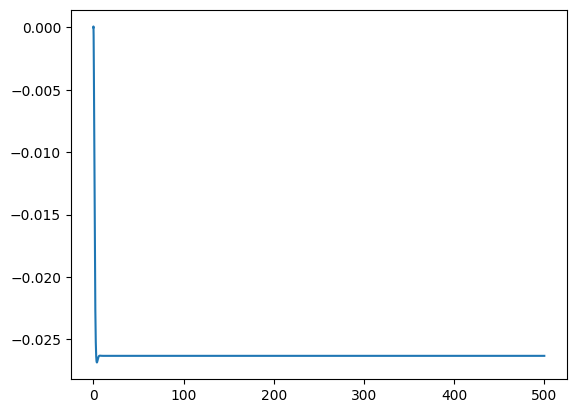

In [34]:
plt.plot(timeDom, zPhyNichtLin[0,:])
# plt.plot(timeDom, zPhyNichtLin[1,:])